# Imports

In [68]:
import argparse
import csv
import os
import random
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.utils as utils
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder

# Get images and labels

In [69]:
# Define the transformations for data augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=10),  # Rotate the image by up to 10 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Flip the image horizontally with a probability of 0.5
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Crop a random portion of the image and resize it to 224x224
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

In [70]:
import os
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset

class PlantDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Create a dictionary to map class names to indices
        class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(os.listdir(root_dir))) if cls_name != 'websites'}

        # Traverse the root directory and collect paths of all image files
        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path) and class_name != 'websites':
                for img_file in os.listdir(class_path):
                    if img_file.endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(class_path, img_file))
                        # Convert class name to one-hot encoding
                        label = [0] * len(class_to_idx)
                        label[class_to_idx[class_name]] = 1
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [71]:
# Define the total dataset
dataset = PlantDataset(root_dir='../Downloading_images/data/'  , transform=train_transforms)

In [72]:
print(len(dataset))

5915


# Make train val and test sets

- Training imagea are 80%
- Validation images are 20%
- Testing images are 20%.

In [73]:
'''
# Define the sizes of subsets for training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

# Create subsets for training, validation, and test sets
train_subset_indices = torch.randperm(len(dataset))[:train_size]
val_subset_indices = torch.randperm(len(dataset))[train_size:train_size+val_size]
test_subset_indices = torch.randperm(len(dataset))[train_size+val_size:]

train_subset = Subset(dataset, train_subset_indices)
val_subset = Subset(dataset, val_subset_indices)
test_subset = Subset(dataset, test_subset_indices)

# Create DataLoader instances for subsets
batch_size = 1
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Print the lengths of DataLoader instances
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))
'''

4732
591
592


### How many plant-images do we have from each class

In [74]:
# Initialize a dictionary to store the count of images for each plant
images_per_plant = {}

# Iterate through subfolders (plants) in the root directory
root_dir = 'C:/Users/asche/OneDrive/Skrivebord/invasive_plant_classifier/Downloading_images/data/' 
for plant_folder in os.listdir(root_dir):
    # Construct the full path to the plant folder
    plant_folder_path = os.path.join(root_dir, plant_folder)
    
    # Check if it's a directory
    if os.path.isdir(plant_folder_path):
        # Count the number of images in the folder
        images_count = len(os.listdir(plant_folder_path))
        
        # Store the count in the dictionary with the plant name as the key
        images_per_plant[plant_folder] = images_count

# Print the count of images for each plant
for plant, count in images_per_plant.items():
    print(f'Number of images for {plant}: {count}')


Number of images for 1293182: 152
Number of images for 1493141: 48
Number of images for 47911: 1241
Number of images for 48537: 1037
Number of images for 52714: 66
Number of images for 57278: 951
Number of images for 75433: 125
Number of images for 76766: 17
Number of images for 77310: 1293
Number of images for 79388: 985
Number of images for websites: 10


In [103]:
# Define the distribution of classes
class_distribution = {
    1293182: 152,
    1493141: 48,
    47911: 1241,
    48537: 1037,
    52714: 66,
    57278: 951,
    75433: 125,
    76766: 17,
    77310: 1293,
    79388: 985,
}

In [105]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

In [109]:
from collections import defaultdict

# Count the occurrences of each class in the dataset
class_counts = defaultdict(int)
for item in dataset:
    # Assuming the label is at index 0 of the tuple
    class_counts[item[0]] += 1

# Filter out classes with less than two members
filtered_labels = [label for label, count in class_counts.items() if count >= 2]

# Get indices for filtered labels
filtered_indices = np.array([idx for idx, label in enumerate(labels) if label in filtered_labels])

# Split indices into train, validation, and test sets while maintaining class distribution
train_indices, test_val_indices = train_test_split(filtered_indices, train_size=0.7, stratify=labels[filtered_indices])
val_indices, test_indices = train_test_split(test_val_indices, train_size=0.5, stratify=labels[filtered_indices][test_val_indices])

# Create subsets based on indices
train_subset = [item for idx, item in enumerate(dataset) if idx in train_indices]
val_subset = [item for idx, item in enumerate(dataset) if idx in val_indices]
test_subset = [item for idx, item in enumerate(dataset) if idx in test_indices]

# Create DataLoader instances for subsets
batch_size = 32  # Define your desired batch size
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


IndexError: arrays used as indices must be of integer (or boolean) type

# Setup classifier

In [75]:
# great paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8747718/ 

## Find labels

In [76]:
import os

# Initialize a set to store unique labels
unique_labels = set()

# Root directory containing subfolders (taxon IDs)
root_dir = '../Downloading_images/data/'

# Iterate over each subfolder (taxon ID) in the root directory
for taxon_id in os.listdir(root_dir):
    # Check if the entry is a directory and exclude 'websites' folder
    if os.path.isdir(os.path.join(root_dir, taxon_id)) and taxon_id != 'websites':
        # Add the taxon ID (subfolder name) to the set of unique labels
        unique_labels.add(taxon_id)

# Calculate the number of unique classes
num_classes = len(unique_labels)

# Print the unique plant names (taxon IDs)
print("Unique Plant Names (Taxon IDs):", unique_labels)
print("Number of Unique Classes:", num_classes)


Unique Plant Names (Taxon IDs): {'79388', '48537', '1293182', '77310', '57278', '47911', '75433', '76766', '52714', '1493141'}
Number of Unique Classes: 10


## Setup the model architecture

In [77]:
''' very advanced model
class PlantClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PlantClassifier, self).__init__()
        # Define convolutional blocks
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Define fully connected layers
        self.fc = nn.Linear(64 * 28 * 28, num_classes)  # Adjust input size based on final feature map size

    def forward(self, x):
        # Forward pass through convolutional blocks
        x = self.conv_block(x)
        # Flatten the output for fully connected layer
        x = x.view(-1, 64 * 28 * 28)  # Adjust based on final feature map size
        # Pass through fully connected layer
        out = self.fc(x)
        return out

# Load pre-trained VGG16 model
vgg16 = models.vgg16()

# Modify the fully connected layer for plant classification
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)

# Optionally freeze pre-trained layers
# for param in vgg16.features.parameters():
#     param.requires_grad = False

# Define your own classifier and its optimizer and loss function
model = PlantClassifier(num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Combine VGG16 convolutional base with your custom classifier
class CombinedModel(nn.Module):
    def __init__(self, vgg, custom_classifier):
        super(CombinedModel, self).__init__()
        self.vgg = vgg.features  # Only taking the convolutional layers
        self.custom_classifier = custom_classifier

    def forward(self, x):
        x = self.vgg(x)
        x = x.view(x.size(0), -1)
        x = self.custom_classifier(x)
        return x

# Instantiate the combined model
combined_model = CombinedModel(vgg16, model)

# Define optimizer and loss function for the combined model
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
'''

' very advanced model\nclass PlantClassifier(nn.Module):\n    def __init__(self, num_classes):\n        super(PlantClassifier, self).__init__()\n        # Define convolutional blocks\n        self.conv_block = nn.Sequential(\n            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),\n            nn.ReLU(),\n            nn.MaxPool2d(kernel_size=2, stride=2),\n            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),\n            nn.ReLU(),\n            nn.MaxPool2d(kernel_size=2, stride=2),\n            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),\n            nn.ReLU(),\n            nn.MaxPool2d(kernel_size=2, stride=2)\n        )\n        # Define fully connected layers\n        self.fc = nn.Linear(64 * 28 * 28, num_classes)  # Adjust input size based on final feature map size\n\n    def forward(self, x):\n        # Forward pass through convolutional blocks\n        x = self.conv_bloc

In [78]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32 * 56 * 56, 2) 

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc(x)
        return x
    
# Instantiate your model
model = SimpleCNN()

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

### Architecture:
- The convolutional blocks consist of three convolutional layers, 
each followed by a ReLU activation and a max pooling layer. 
- This helps in extracting hierarchical features from the input images.
-The output feature maps are downsampled through max pooling layers, 
ensuring consistent output shapes regardless of the input size.
- The fully connected layer's input size is adjusted based on the final 
feature map size after downsampling.

# Run the training loop

In [79]:
learning_rate = 0.2

# Apply dropout regularization
dropout_rate = 1  
model_dropout = nn.Sequential(
    nn.Dropout(dropout_rate),
    model
)

# Apply L2 regularization (weight decay)
weight_decay = 2  
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [80]:
# Define the number of epochs and early stopping parameters
num_epochs = 25
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
early_stopping_counter = 0

# Lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define the directory where the models and losses will be saved
models_directory = "./models/"

# Ensure the directory exists, create it if it doesn't
if not os.path.exists(models_directory):
    os.makedirs(models_directory)

# Define the filename for the CSV file containing the losses
losses_file = f"./models/{taxon_id}_losses.csv"

# Open the file in write mode ('w') with newline='' to prevent extra newline characters
with open(losses_file, 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)
    
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0

    for images, _ in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        
        label_value = 0  # or any other label you want to assign
        labels = torch.full((images.size(0),), label_value, dtype=torch.long)

        loss = F.cross_entropy(outputs, labels)
        train_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_predictions += labels.size(0)

        loss.backward()
        optimizer.step()

    # Calculate average training loss and accuracy
    train_loss /= len(train_dataloader)
    train_accuracy = correct_train_predictions / total_train_predictions

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0

    with torch.no_grad():
        for images, _ in val_dataloader:
            outputs = model(images)
            
            # For simplicity, let's assume the label for all images is 0
            labels = torch.zeros(images.size(0), dtype=torch.long)  # Batch size number of zeros
            
            loss = F.cross_entropy(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val_predictions += (predicted == labels).sum().item()
            total_val_predictions += labels.size(0)

    # Calculate average validation loss and accuracy
    val_loss /= len(val_dataloader)
    val_accuracy = correct_val_predictions / total_val_predictions

    # Save training and validation losses and accuracies
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Save training and validation losses to the CSV file
    with open(losses_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        if epoch == 0:  # Write header if it's the first epoch
            writer.writerow(['Epoch', 'Train Loss', 'Val Loss'])
        writer.writerow([epoch, train_loss, val_loss])

    # Check for early stopping based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break


    # Save the trained model in the "./models" folder
    torch.save(model.state_dict(), f"./models/{taxon_id}_model.pth")       

    # Print training and validation loss and accuracy
    print(f'Epoch {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
    f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 0, Training Loss: 29.2290, Validation Loss: 0.0000, Training Accuracy: 0.9941, Validation Accuracy: 1.0000
Epoch 1, Training Loss: 266.8431, Validation Loss: 0.0000, Training Accuracy: 0.9981, Validation Accuracy: 1.0000
Epoch 2, Training Loss: 297.4358, Validation Loss: 0.0000, Training Accuracy: 0.9983, Validation Accuracy: 1.0000
Early stopping at epoch 3


## Loss curve & accuracy curve

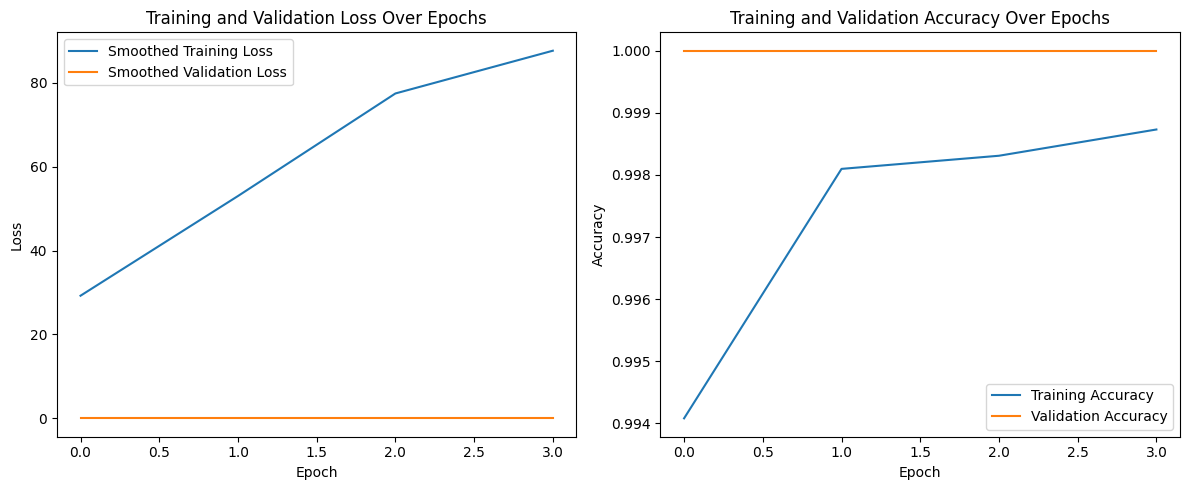

In [81]:
# Optional: Smoothing the loss curves for better visualization
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_train_losses = smooth_curve(train_losses)
smooth_val_losses = smooth_curve(val_losses)

# Plotting training and validation losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(smooth_train_losses, label='Smoothed Training Loss')
plt.plot(smooth_val_losses, label='Smoothed Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Testing

In [82]:
# Testing phase
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for images, labels in test_dataloader:  # Assuming you have a separate test dataloader
        outputs = model(images)

        # For simplicity, let's assume the label for all images is 0
        labels = torch.zeros(images.size(0), dtype=torch.long)  # Batch size number of zeros
        
        # Calculate loss
        # Ensure labels are converted to tensors if needed
        # Assuming labels are already tensors, but if not, you can convert them like this:
        # labels = torch.tensor(labels, dtype=torch.long)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get the index of the maximum output
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate average test loss
test_loss /= len(test_dataloader)

# Calculate accuracy
accuracy = correct_predictions / total_predictions

# Print test loss and accuracy
print(f'Test Loss: {test_loss}, Accuracy: {accuracy * 100:.2f}%')


Test Loss: 0.0, Accuracy: 100.00%


In [102]:
label_counts = {}

# Iterate over the test dataset to count the occurrences of each label
for images, labels in train_dataloader:
    for label in labels:
        label = label.item()
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

# Print the counts of each label
for label, count in label_counts.items():
    print(f"Label {label}: {count} images")


Label 0: 42588 images
Label 1: 4732 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


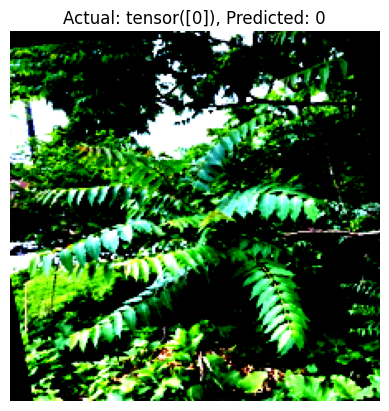

Actual: tensor([0]), Predicted: 0


In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Set model to evaluation mode
model.eval()

# Choose a random batch from the test dataset
for batch in test_dataloader:
    images, labels = batch
    random_index = np.random.randint(len(images))
    image, label = images[random_index], labels[random_index]
    break  # Break after the first batch to get one random image

# Make prediction
with torch.no_grad():
    output = model(image.unsqueeze(0))  # Add batch dimension

predicted_label = torch.argmax(output, dim=1).item()

# Display the image
plt.imshow(image.permute(1, 2, 0))  # If image is in tensor format, permute dimensions
plt.axis('off')
plt.title(f'Actual: {label}, Predicted: {predicted_label}')
plt.show()

print(f'Actual: {label}, Predicted: {predicted_label}')